In [1]:
# SPDX-FileCopyrightText: © 2021-2022 Stefano Zacchiroli <zack@upsilon.cc>
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
dataset_dir = "/srv/softwareheritage/annex/public/dataset/license-blobs/2022-04-25"
# basename = "blobs-sample20k"  # to only analyze blob sample
basename = "blobs"
blob_dir = f"{dataset_dir}/{basename}"

stats_csv = f"{dataset_dir}/{basename}-fileinfo.csv"
words_csv = f"{dataset_dir}/{basename}-wordfreqs.csv"
scancode_csv = f"{dataset_dir}/{basename}-scancode.csv"

do_mining = False  # change to True to (re-)mine metadata (SLOW!)
out_data_dir = "/home/zack/paper-licenseblobs-dataset-ext/data"
out_fig_dir = "/home/zack/paper-licenseblobs-dataset-ext/figs"

import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors


# Analyze license blob descriptive statistics


In [3]:
if not os.path.isfile(stats_csv):
    subprocess.run(["unzstd", "--force", stats_csv + ".zst"], check=True)
stats = pd.read_csv(stats_csv)
stats


sha1   mime_type  encoding  \
0        000001ba9d81054148d67470d2dd47ab1ac8df04  text/plain  us-ascii   
1        000008ebd0fd9d68f7fac3e9b364bec209fd02ed  text/plain  us-ascii   
2        0000099acfb35191e392aaff89df72fee928a653   text/html  us-ascii   
3        00000c557cd17dfa1d224d9e0e2b257df2ffe6e1  text/plain  us-ascii   
4        00000ce16ab27e1a6d54cb6315da987dba04c964  text/plain  us-ascii   
...                                           ...         ...       ...   
6859185  fffff089eb2a9e5ef114eba5fb67739e0a3fe038  text/plain  us-ascii   
6859186  fffff4987863d15244f1460cbb7e35939e3e7f87  text/plain  us-ascii   
6859187  fffff7190dd72d7ce094997fbf2ab7c78bce9d2b  text/plain  us-ascii   
6859188  fffff79d9923034d35285455d427701da3efab1f  text/plain  us-ascii   
6859189  fffffd14f6140728c5bb2d0c652eae591629f138  text/plain  us-ascii   

         line_count  word_count  size  
0              21.0       168.0  1066  
1               7.0        24.0   257  
2               NaN         NaN  3542  
3              21.0       170.0  1077  
4              13.0        83.0   588  
...             ...         ...   ...  
6859185        21.0       169.0  1072  
6859186        21.0       169.0  1072  
6859187        21.0       169.0  1090  
6859188        58.0       143.0  1271  
6859189        21.0       170.0  1077  

[6859190 rows x 6 columns]

In [4]:
stats.describe()

line_count    word_count          size
count  5.667116e+06  5.667116e+06  6.859190e+06
mean   1.307410e+02  8.610119e+02  1.015964e+04
std    4.511294e+03  1.450112e+04  2.450215e+05
min    1.000000e+00  0.000000e+00  0.000000e+00
25%    2.000000e+01  1.680000e+02  1.065000e+03
50%    2.100000e+01  1.690000e+02  1.080000e+03
75%    2.700000e+01  1.890000e+02  2.241000e+03
max    6.373094e+06  7.374871e+06  1.909773e+08

## License blob size distribution — by bytes, lines, words


In [5]:
def plot_size_distrib(stats, label, bins=100):
    pct99 = stats[label].quantile(0.99)
    stats[stats[label] <= pct99][label].plot.hist(log=True, bins=bins)


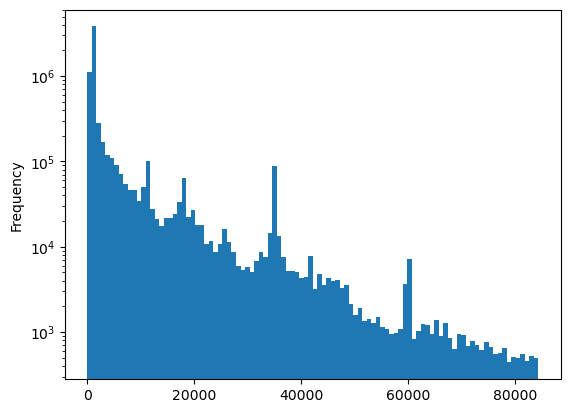

In [6]:
plot_size_distrib(stats, "size")

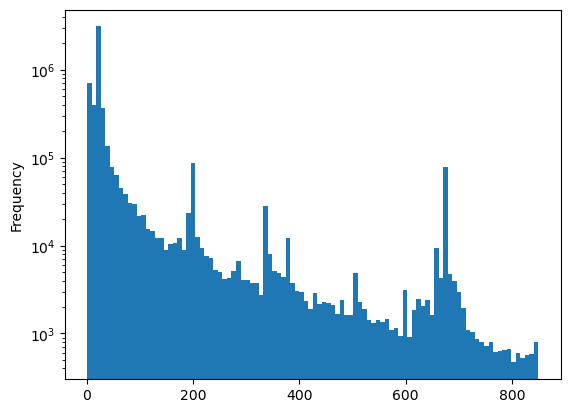

In [7]:
plot_size_distrib(stats, "line_count")

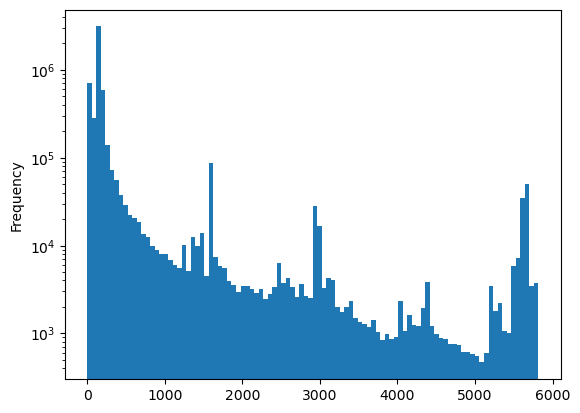

In [8]:
plot_size_distrib(stats, "word_count")

## License blob file types — top 20


In [9]:
mime_top = stats["mime_type"].value_counts().nlargest(20).rename_axis('mime_type').reset_index(name='counts')
mime_top.to_csv(out_data_dir + "/mime_top.csv", index=False)
mime_top


mime_type   counts
0                  text/plain  5721424
1                   text/html   723593
2                  text/x-php    65275
3                 text/x-java    61554
4    application/octet-stream    49195
5                    text/xml    49101
6                   image/png    22912
7            application/json    20327
8        text/x-script.python    15703
9            application/gzip    12367
10                   text/rtf    11956
11                text/x-ruby    11646
12                  text/x-po    11102
13                   text/x-c    11084
14                 text/x-c++    10549
15  application/x-java-applet     6584
16              image/svg+xml     6493
17                 text/x-tex     6286
18     text/x-bytecode.python     4701
19            application/csv     4674

In [10]:
stats_total = len(stats)
text_plain_pct = len(stats.loc[stats["mime_type"] == "text/plain"]) * 100 / stats_total
text_pct = len(stats.loc[stats["mime_type"].str.startswith("text/")]) * 100 / stats_total
(text_plain_pct, text_pct)

(83.41253121724286, 97.86463124654661)

## License blob  file encodings


In [11]:
encoding_top = stats["encoding"].value_counts().rename_axis('encoding').reset_index(name='counts')
encoding_top.to_csv(out_data_dir + "/encoding_top.csv", index=False)
encoding_top


encoding   counts
0      us-ascii  5517915
1         utf-8  1154191
2        binary   121966
3    iso-8859-1    49251
4  unknown-8bit    13597
5      utf-16le     2125
6      utf-16be      143
7        ebcdic        2

# Mine word frequencies for textual licenses

For license blobs in textual format collect word frequencies.

Executing this step took about 1h10m, on a SSD disk and with no parallelism.


In [12]:
%%time
def mine_word_frequency(df, out_fname):
    from collections import Counter
    import re
    import string

    WORD_SEP_RE = re.compile(r"\W+")

    word_freqs = Counter()
    blob_count = 0
    # textual licenses that are most likely to be decodable as utf-8
    text_blobs = df[(df.mime_type == "text/plain") & (df.encoding.isin(["us-ascii", "utf-8", "iso-8859-1"]))]
    for sha1 in text_blobs["sha1"]:
        blob_count += 1
        if blob_count % 100_000 == 0:
            print(f"blobs processed thus far: {int(blob_count/1000)}K ...")
        fname = f"{blob_dir}/{sha1[0:2]}/{sha1[2:4]}/{sha1}"
        try:
            with open(fname, encoding="utf-8") as f:
                for line in f:
                    word_freqs.update((word for word
                                       in WORD_SEP_RE.split(line.lower())
                                       if word))
        except ValueError:  # decoding errors
            continue

    with open(out_fname, "w") as csv:
        csv.write("word,frequency\n")
        for (word, freq) in word_freqs.items():
            csv.write(f"{word},{freq}\n")


if do_mining:
    mine_word_frequency(stats, words_csv)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


# Analyze word frequencies

**TODO**


In [14]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = stopwords.words('english')
stop_words.extend(string.digits)
stop_words.extend(string.ascii_lowercase)

words = pd.read_csv(words_csv).sort_values(by="frequency", ascending=False)
interesting_words = words[~words["word"].isin(stop_words)]
interesting_words


[nltk_data] Downloading package stopwords to /home/zack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


word  frequency
20          software   73848600
1            license   65120569
2          copyright   53813792
33               use   36492256
223             work   35606158
...              ...        ...
9322668     7cfe06d7          1
9322669     832d372e          1
9322670     60c18382          1
9322671     2f579c22          1
18697976  renehaavre          1

[18697796 rows x 2 columns]

In [15]:
words_top = interesting_words.nlargest(30, columns="frequency")
words_top.to_csv(out_data_dir + "/words_top.csv", index=False)
words_top


word  frequency
20       software   73848600
1         license   65120569
2       copyright   53813792
33            use   36492256
223          work   35606158
28        without   27946481
30      including   27065320
206        source   25432478
52         notice   25007288
50     conditions   24425279
53          shall   22558504
59       provided   22523413
2395        gplv2   21709671
51384        nasl   20805400
49      following   19333506
18           copy   18296628
129           may   18092010
107           com   17343283
6      permission   16720683
340          must   16454459
211          code   15776625
32         rights   15413909
68     warranties   15202030
64        implied   15025359
83      liability   14817590
157         terms   14639581
207          form   14191924
67        limited   14157137
81        damages   13337383
73        purpose   13227506

In [16]:
if not os.path.isfile(scancode_csv):
    subprocess.run(["unzstd", "--force", scancode_csv + ".zst"], check=True)
scancode = pd.read_csv(scancode_csv)
scancode


sha1  \
0        00000ce16ab27e1a6d54cb6315da987dba04c964   
1        000024bb721720b747c999266c01628b9f51383b   
2        00001b371f89f46df23f2255152cf613aa08d3ab   
3        00001d83535c8cd70f384571fe3767b4ced0a56a   
4        00002b4d8fd107b54038a624ed16a3fb6dcc2737   
...                                           ...   
8665009  ff4f3a7ac3dd2fc0a066e88964d583af6601d653   
8665010  ff4f3a7ac3dd2fc0a066e88964d583af6601d653   
8665011  ff4f3a7ac3dd2fc0a066e88964d583af6601d653   
8665012  ff4f3a7ac3dd2fc0a066e88964d583af6601d653   
8665013  ff4f3a7ac3dd2fc0a066e88964d583af6601d653   

                                               license   score  
0                                           Apache-2.0  100.00  
1                                                  MIT  100.00  
2                                                  MIT  100.00  
3                                                  MIT  100.00  
4                                                  MIT  100.00  
...                                                ...     ...  
8665009                                     Apache-2.0   90.00  
8665010                                     Apache-2.0   94.17  
8665011                                   BSD-3-Clause   95.00  
8665012  LicenseRef-scancode-unknown-license-reference  100.00  
8665013                    LicenseRef-scancode-unknown  100.00  

[8665014 rows x 3 columns]

In [17]:
scancode["score"].describe(percentiles=[.25, .5, .75, .9, .99])


count    8.665014e+06
mean     9.305172e+01
std      1.806775e+01
min      1.520000e+00
25%      9.900000e+01
50%      1.000000e+02
75%      1.000000e+02
90%      1.000000e+02
99%      1.000000e+02
max      1.000000e+02
Name: score, dtype: float64

In [18]:
scancode_top = scancode["license"].value_counts().nlargest(10).rename_axis('license').reset_index(name='counts')
scancode_top["pct"] = scancode_top["counts"] * 100 / len(scancode)
scancode_top.to_csv(out_data_dir + "/scancode_top.csv", index=False)

scancode_top.loc[scancode_top["license"] == "LicenseRef-scancode-unknown-license-reference", "license"] = "unknown"
scancode_top.loc[scancode_top["license"] == "LicenseRef-scancode-public-domain", "license"] = "public domain"
scancode_top.loc[len(scancode_top)] = ["(other licenses)", len(scancode) - scancode_top["counts"].sum(), 100 - scancode_top["pct"].sum()]

scancode_top



license   counts        pct
0                MIT  3402267  39.264414
1       BSD-3-Clause   628803   7.256803
2         Apache-2.0   472342   5.451139
3            unknown   290382   3.351201
4   GPL-1.0-or-later   282296   3.257883
5   GPL-2.0-or-later   249793   2.882777
6       GPL-2.0-only   245950   2.838426
7       GPL-3.0-only   207604   2.395888
8       BSD-2-Clause   175413   2.024382
9      public domain   138396   1.597181
10  (other licenses)  2571768  29.679906

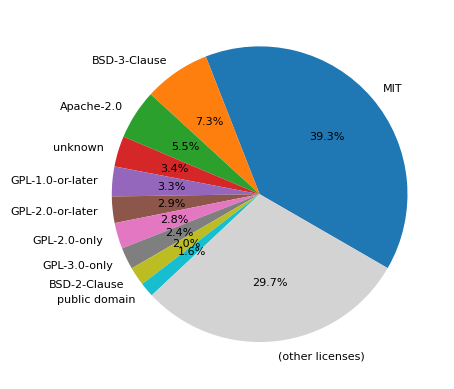

In [19]:
scancode_top["counts"].plot.pie(
    labels=scancode_top["license"],
    autopct="%.1f%%",
    fontsize=8,
    colors=(list(colors.TABLEAU_COLORS.keys()) + ['lightgray']),
    startangle=330,
 )
plt.ylabel("")
plt.savefig(out_fig_dir + "/scancode_top.pdf")
